**XÂY DỰNG MÔ HÌNH LỌC THƯ RÁC DỰA TRÊN XÁC XUẤT NAIVE BAYES**








In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm



3. Kiểm tra tập dữ liệu
  - Mở tệp SMSSpamCollection bằng hàm read_csv() của thư viện Pandas, đồng thời đặt tên cho hàng tiêu đề tương ứng với các cột
  - sms_spam.head() trả về *n* hàng đầu tiên của tập dữ liệu

In [5]:
data = pd.read_csv('./SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])
data.head(n=10)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


- Kiểm tra số lượng thư được phân loại là ham(thư bình thường) so với thư spam(rác)


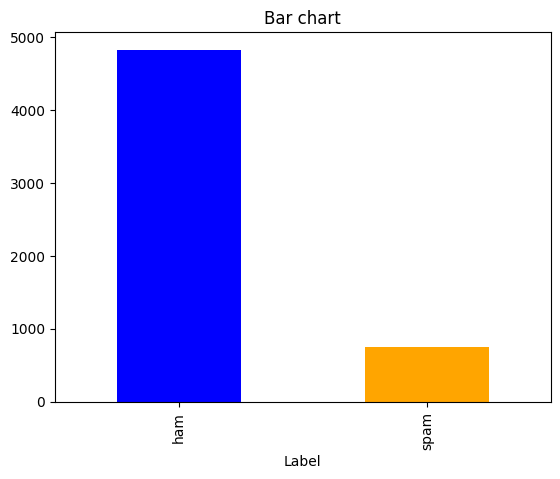

In [6]:
count_Class=pd.value_counts(data["Label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

- Đếm số lượng từ thường xuất hiện trong thư ham và thư spam


In [7]:
count1 = Counter(" ".join(data[data['Label']=='ham']["SMS"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['Label']=='spam']["SMS"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

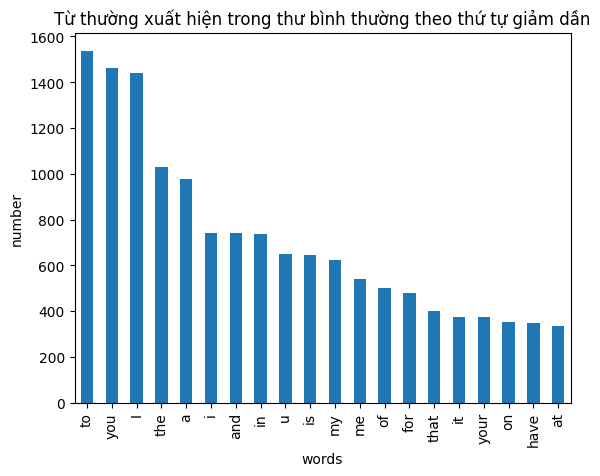

In [8]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('Từ thường xuất hiện trong thư bình thường theo thứ tự giảm dần')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

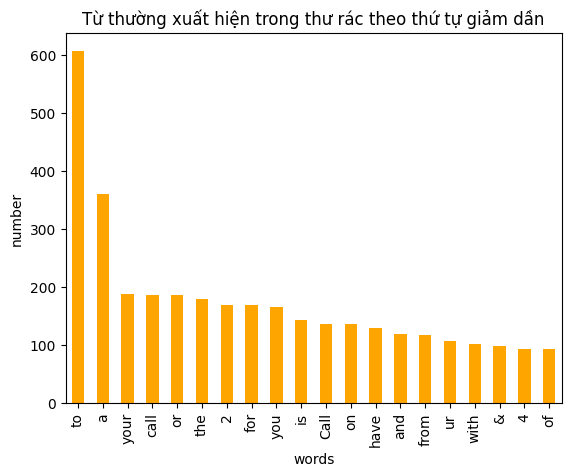

In [9]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('Từ thường xuất hiện trong thư rác theo thứ tự giảm dần')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

3. Trích xuất đặc trưng tập dữ liệu
- CountVectorizer của thư viện sklearn sẽ thực hiện tiền xử lý văn bản(tập dữ liệu) bằng các phương pháp như lowercase(đưa về chũ thường), remove stopword(loại bỏ các từ dừng), tokenize(chia câu thành các từ),... Sau đó sẽ vecto hóa các dữ liệu và trả về một ma trận với số hàng là tổng số các thư có trong tập dữ liệu và số cột là số các từ ngữ riêng biệt trong tất cả các thư(bag of words)
*source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [10]:
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["SMS"])
np.shape(X)
print(X.toarray()[:,2])

[0 0 0 ... 0 0 0]


4. Chia tập dữ liệu thành tập huấn luyện thành tập huấn luyện và tập kiểm thử, ở đây ta chia tập dữ liệu thành tập huấn luyện(2/3) tập ban đầu và tập kiểm thử(1/3). X_train và X_test chứa các ma trận vecto hóa đặc trưng các thư đã được xử lý trước đó, y_train và y_test chứa các nhãn được gán tương ứng với các thư

* Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [11]:
data["Label"]=data["Label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['Label'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])
print([np.shape(y_train), np.shape(y_test)])

[(3733, 8444), (1839, 8444)]
[(3733,), (1839,)]


5. Tiến hành lựa chọn siêu tham số cho mô hình
- Chúng ta sẽ sử dụng mô hình MultinomialNB của thư viện Sklearn
- Chúng ta sẽ xây dựng một mảng chứa các giá trị alpha, 4 mảng score_train, score_test, recall_test và precision_test chứ các giá trị trên tương ứng với giá trị alpha, sau đó so sánh tìm ra giá trị alpha phù hợp nhất cho mô hình
* Source: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html


In [12]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

- Với các mảng giá trị trên, ta tiến hành ghép để tạo ra một ma trận với các cột lần lượt là alpha, Train Accuracy, Test Accuracy Test Recall và Test Precision tương ứng và chuyển ma trận này thành một DataFrame


In [14]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns =
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.997589,0.976618,0.939024,0.891892
1,0.11001,0.997053,0.976074,0.963415,0.871324
2,0.22001,0.996518,0.976074,0.963415,0.871324
3,0.33001,0.996785,0.977705,0.967480,0.878229
4,0.44001,0.996518,0.977705,0.967480,0.878229
5,0.55001,0.995446,0.978249,0.967480,0.881481
6,0.66001,0.995178,0.978249,0.963415,0.884328
7,0.77001,0.994910,0.977705,0.959350,0.883895
8,0.88001,0.994642,0.978249,0.955285,0.890152
9,0.99001,0.994374,0.978249,0.951220,0.893130


+ Lọc lấy các hàng có giá trị Test Precision (Chính xác dự đoán trên tập kiểm tra)

In [15]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.290010
Train Accuracy     0.975355
Test Accuracy      0.978793
Test Recall        0.841463
Test Precision     1.000000
Name: 139, dtype: float64

In [16]:
models[models['Test Precision']==1].head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
139,15.29001,0.975355,0.978793,0.841463,1.0
140,15.40001,0.975087,0.978793,0.841463,1.0
141,15.51001,0.974819,0.977705,0.833333,1.0
142,15.62001,0.974819,0.977705,0.833333,1.0
143,15.73001,0.974819,0.977705,0.833333,1.0
144,15.84001,0.974819,0.977705,0.833333,1.0
145,15.95001,0.974551,0.977705,0.833333,1.0
146,16.06001,0.974551,0.976618,0.825203,1.0
147,16.17001,0.974283,0.976618,0.825203,1.0
148,16.28001,0.974283,0.976618,0.825203,1.0


- Có thể thấy có nhiều hàng có giá trị Test Accuracy là 1, ta tiếp tục lọc theo giá trị Test Accuracy lớn nhất để tìm ra tham số alpha phù hợp nhất
- Giá trị best_index chứa chỉ số(hàng thứ bao nhiêu trong ma trận) mà chứa giá tị alpha phù hợp nhất

In [17]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
models.iloc[best_index, :]

alpha             15.290010
Train Accuracy     0.975355
Test Accuracy      0.978793
Test Recall        0.841463
Test Precision     1.000000
Name: 139, dtype: float64

5. Tiến hành sử dụng model với siêu tham số đã tìm được để huấn luyện và đánh giá dựa trên ma trận confusion

In [18]:
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)

MultinomialNB(alpha=15.29001)

In [19]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Ham', 'Spam'])

,Predicted Ham,Predicted Spam
Ham,1593,0
Spam,39,207


=> Kết quả trả về khi dự đoán thư thường đạt sự chính xác cao 100%, trong khi đó vẫn còn một số lượng khá(15%) số thư rác được phân loại vào thư thường
* Nguyên nhân dẫn đến vấn đề này có thể đến từ việc có nhiều từ xuất hiện nhiều lần trong cả 2 văn bản(a,an,the,..) nhưng những từ này không có nhiều giá trị trong việc trích xuất đặc trưng nên có thể dẫn đến sai sót trong quá trình phân loại


6. So sánh các mô hình phân loại thư rác (k-NN, NaiveBayes và SVM)

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [22]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [23]:
nb_predictions = bayes.predict(X_test)
knn_predictions = knn.predict(X_test)
svm_predictions = svm_model.predict(X_test)
model_compare = {
    'Model': ['Naive Bayes', 'k-NN', 'SVM'],
    'Train Accuracy': [bayes.score(X_train, y_train), knn.score(X_train, y_train), svm_model.score(X_train, y_train)],
    'Test Accuracy': [bayes.score(X_test, y_test), knn.score(X_test, y_test), svm_model.score(X_test, y_test)],
    'Precision': [metrics.precision_score(y_test, nb_predictions), metrics.precision_score(y_test, knn_predictions), metrics.precision_score(y_test, svm_predictions)],
    'Recall': [metrics.recall_score(y_test, nb_predictions), metrics.recall_score(y_test, knn_predictions), metrics.recall_score(y_test, svm_predictions)]
}

df = pd.DataFrame(model_compare)
print(df)

         Model  Train Accuracy  Test Accuracy  Precision    Recall
0  Naive Bayes        0.975355       0.978793        1.0  0.841463
1         k-NN        0.946156       0.925503        1.0  0.443089
2          SVM        0.999732       0.988581        1.0  0.914634
